In [2]:
import yolo
from yolo import YOLO

import torch
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn import metrics


# Use GPU if available
device = "0" if torch.cuda.is_available() else "cpu"
if device == "0":
    torch.cuda.set_device(0) # Set to your desired GPU number

from plotting_utils import plot_grid_search_losses, plot_map_hist, plot_map_hist_s

module_path = os.path.abspath(os.path.join('..'))
print(module_path)

if module_path not in sys.path:
    sys.path.append(module_path)

#import data_preprocessing.visualization_utils as visutils
from model.constants import DATA_PATH, DATASETS_MAPPING, MODELS_PATH, NB_EPOCHS, BATCH_SIZE, PATIENCE, OPTIMIZER, TRAINING_IOU_THRESHOLD, CONF_THRESHOLD, NB_CONF_THRESHOLDS, IOU_THRESHOLD


/vast/palmer/home.grace/eec42/BirdDetector/src


## **Gain grid searches**
## on {source:Penguins, target:Palmyra}

p= 0.75
p= 1.0
p= 1.5
p= 2
p= 3
p= 5
p= 10
['0.75', '1.0', '1.5', '2', '3', '5', '10']
p= 0.5
p= 0.75
p= 1.0
p= 1.5
p= 2
p= 3
p= 5
p= 10
['0.5', '0.75', '1.0', '1.5', '2', '3', '5', '10']
p= 0.5
p= 0.75
p= 1.0
p= 1.5
p= 2
p= 3
p= 5
p= 10
['0.5', '0.75', '1.0', '1.5', '2', '3', '5', '10']


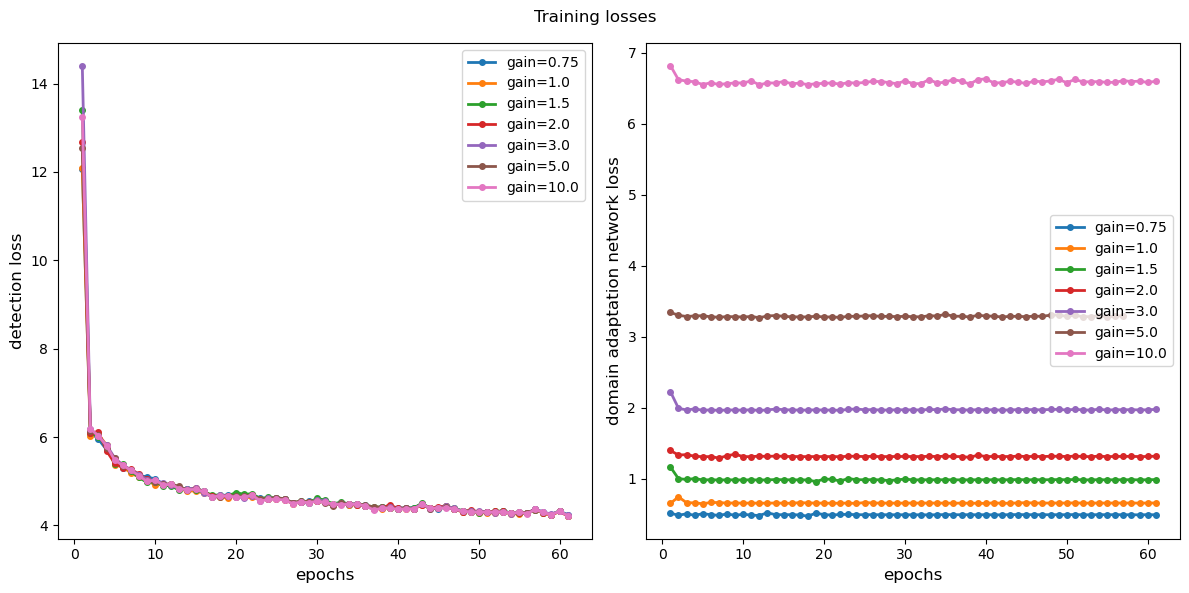

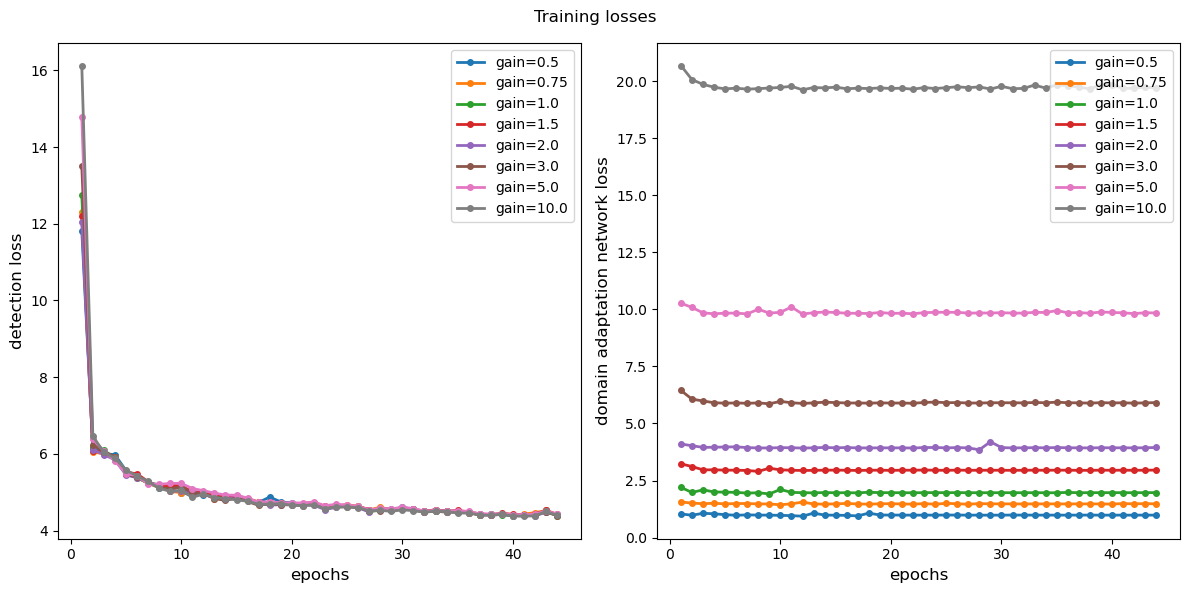

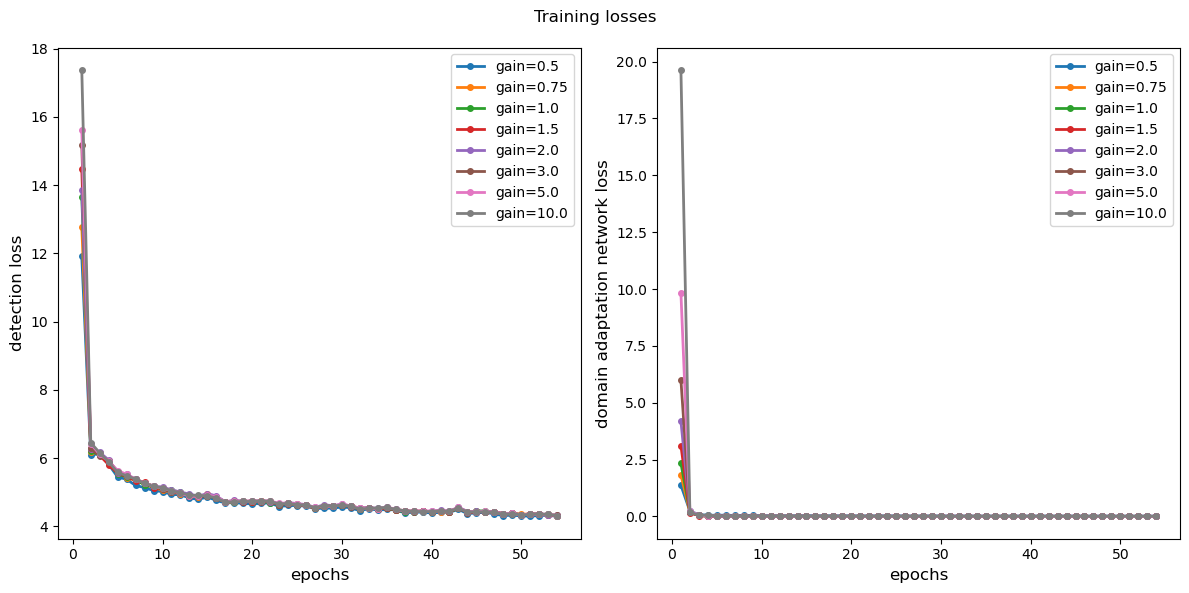

In [2]:
maps = {'pe_palmyra_10percentbkgd': {'DAN': {'gains': ['0.75','1.0','1.5','2','3','5','10'], 
                                             'map_target': [0.74, 0.57, 0.76, 0.7, 0.49, 0.62, 0.59],
                                             'map_source': [0.92, 0.94, 0.94, 0.92, 0.93, 0.91, 0.91],
                                             'map': [0.91, 0.92, 0.93, 0.91, 0.9, 0.9, 0.89]},
                                    'multiDAN': {'gains': ['0.5','0.75','1.0','1.5','2','3','5','10'],
                                                  'map_target': [0.8, 0.65, 0.53, 0.63, 0.68, 0.6, 0.67, 0.52],
                                                  'map_source': [0.92, 0.92, 0.92, 0.94, 0.93, 0.94, 0.92, 0.91],
                                                  'map': [0.91, 0.91, 0.9, 0.92, 0.91, 0.92, 0.9, 0.88],},
                                    'featdist': {'gains': ['0.5','0.75','1.0','1.5','2','3','5','10'], 
                                                 'map_target': [0.63, 0.62, 0.66, 0.65, 0.61, 0.57, 0.7, 0.32],
                                                 'map_source': [0.9, 0.92, 0.92, 0.92, 0.92, 0.89, 0.91, 0.94],
                                                 'map': [0.89, 0.9, 0.91, 0.91, 0.9, 0.87, 0.9, 0.9],},}
        }

CSV_FILE = "results.csv"

# Predictions parameters
eps = 1e-8

DATASET_NAME = list(maps.keys())[0]
SUBDATASETS = DATASETS_MAPPING[DATASET_NAME]['datasets']
MODEL_NAME_PREFIX_ = DATASET_NAME + '_'
models_folder = '/home/eec42/BirdDetector/runs/pe_palm_gain_search/'

for task in maps[DATASET_NAME].keys():

    MODEL_NAME_PREFIX = task + "_" + MODEL_NAME_PREFIX_
    GAINs = maps[DATASET_NAME][task]['gains']
    plot_grid_search_losses(task, models_folder, MODEL_NAME_PREFIX, "gain", GAINs)
    map = maps[DATASET_NAME][task]['map']
    map_target = maps[DATASET_NAME][task]['map_target']
    map_source = maps[DATASET_NAME][task]['map_source']
    plot_map_hist(models_folder, MODEL_NAME_PREFIX, 'gain', GAINs, map)
    plot_map_hist_s(models_folder, MODEL_NAME_PREFIX, 'gain', GAINs, map, map_source, map_target)



## **Original YOLO models**

In [ ]:
maps = {'pe_palmyra_10percentbkgd': {'map_target': ,
                                     'map_source': ,
                                     'map': },
        'pepf_10percent_background': {'map_target': ,
                                     'map_source': ,
                                     'map': },
        'pepf_palmyra_10percentbkgd': {'map_target': ,
                                     'map_source': ,
                                     'map': },
        }

{'source': ['global_birds_penguins', 'global_birds_pfeifer']}
{'source': ['global_birds_penguins', 'global_birds_pfeifer', 'global_birds_palmyra']}


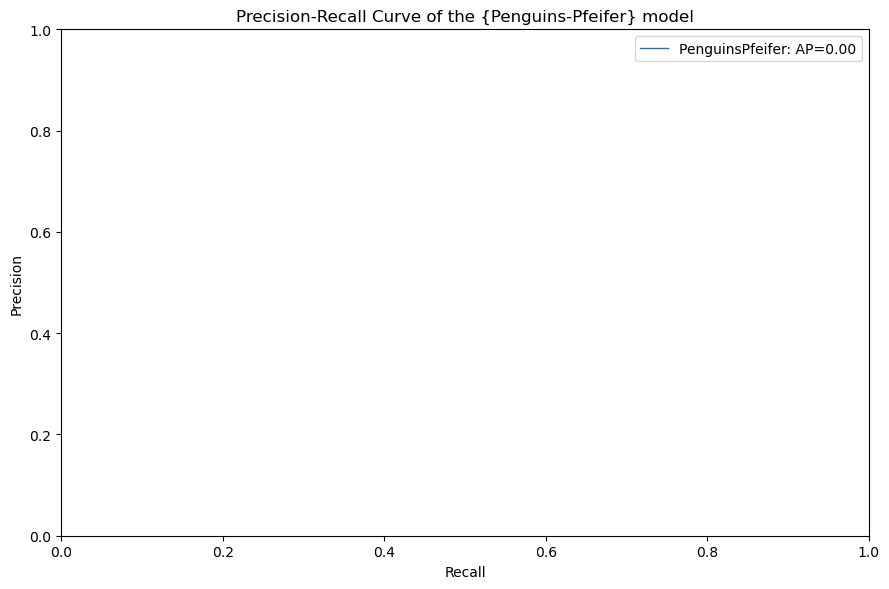

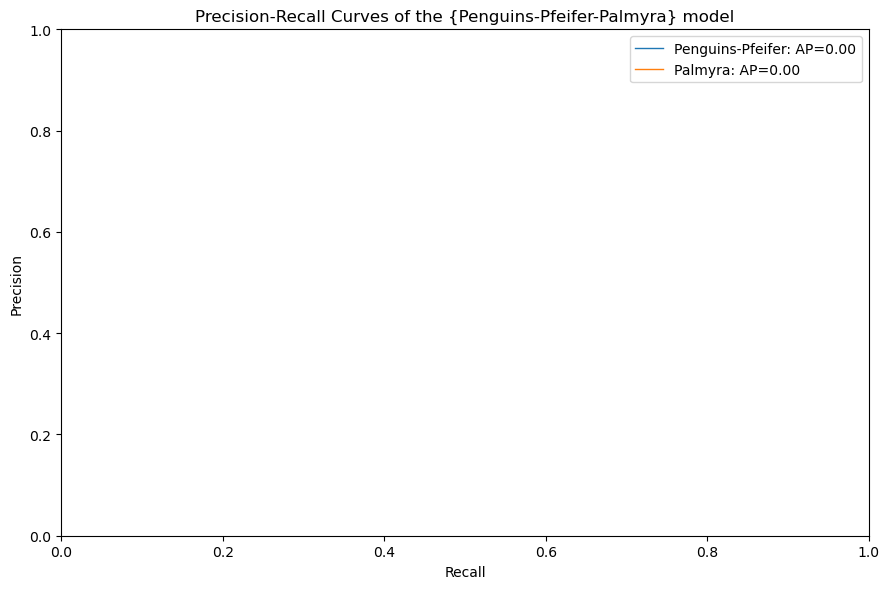

In [5]:
EVAL_FILE = "evaluation_results.json"

# Predictions parameters
eps = 1e-8

models_folder = '/home/eec42/BirdDetector/runs/original_YOLO_models/'

# First model - Penguins+Pfeifer
DATASET = 'pepf_10percent_background'
SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']
MODEL_NAME = 'YOLO_' + DATASET
model_dir = os.path.join(models_folder, MODEL_NAME)
results = os.path.join(model_dir, 'eval', EVAL_FILE)
with open(results) as json_data:
    data = json.load(json_data)
    json_data.close()

conf_thresholds = data['confidence_thresholds']
FN = np.array(data['results_metrics']['FN'])
FP = np.array(data['results_metrics']['FP'])
TN = np.array(data['results_metrics']['TN'])
TP = np.array(data['results_metrics']['TP'])
print(data['datasets'])

global_precision = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
global_recall = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
global_f1 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
best_f1 = np.max(global_f1)
best_f1_conf = conf_thresholds[np.argmax(global_f1)]


# Second model - Penguins+Pfeifer+Palmyra
DATASET = 'pepf_palmyra_10percentbkgd'
SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']
MODEL_NAME = 'YOLO_' + DATASET
model_dir = os.path.join(models_folder, MODEL_NAME)
results = os.path.join(model_dir, 'eval', EVAL_FILE)
with open(results) as json_data:
    data = json.load(json_data)
    json_data.close()

conf_thresholds = data['confidence_thresholds']
FN = np.array(data['results_metrics']['FN'])
FP = np.array(data['results_metrics']['FP'])
TN = np.array(data['results_metrics']['TN'])
TP = np.array(data['results_metrics']['TP'])
print(data['datasets'])

source_datasets_indices = [0, 1]
target_datasets_indices = [2]

source_precision = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FP[source_datasets_indices, :], axis=0) + eps)
source_recall = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FN[source_datasets_indices, :], axis=0) + eps)
target_precision = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FP[target_datasets_indices, :], axis=0) + eps)
target_recall = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FN[target_datasets_indices, :], axis=0) + eps)

global_precision_2 = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
global_recall_2 = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
                                     
source_f1 = 2*(source_precision*source_recall)/(source_precision+source_recall+eps)
target_f1 = 2*(target_precision*target_recall)/(target_precision+target_recall+eps)
global_f1_2 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
best_f1_2 = np.max(global_f1)
best_f1_conf_2 = conf_thresholds[np.argmax(global_f1)]


# Compute Average Precision & plot PR curves
global_AP = metrics.auc(y=global_precision, x=global_recall)
source_AP = metrics.auc(y=source_precision, x=source_recall)
target_AP = metrics.auc(y=target_precision, x=target_recall)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)
ax.plot(global_recall, global_precision,linewidth=1, label=f'PenguinsPfeifer: AP={global_AP:.2f}')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc='upper right')
ax.set_title('Precision-Recall Curve of the {Penguins-Pfeifer} model')
fig.savefig(os.path.join(models_folder, MODEL_NAME + 'PRcurve_Global.jpg'), dpi=250)
plt.show()
plt.close(fig)


fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)
ax.plot(source_recall, source_precision, linewidth=1, label=f'Penguins-Pfeifer: AP={source_AP:.2f}')  # plot(recall, precision)
ax.plot(target_recall, target_precision, linewidth=1, label=f'Palmyra: AP={target_AP:.2f}')  # plot(recall, precision)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc='upper right')
ax.set_title('Precision-Recall Curves of the {Penguins-Pfeifer-Palmyra} model')
fig.savefig(os.path.join(models_folder, MODEL_NAME + 'PRcurve_SourceTarget.jpg'), dpi=250)
plt.show()
plt.close(fig)


## **Architectures comparison on a given dataset**

{'source': ['global_birds_palmyra', 'terns_africa']}


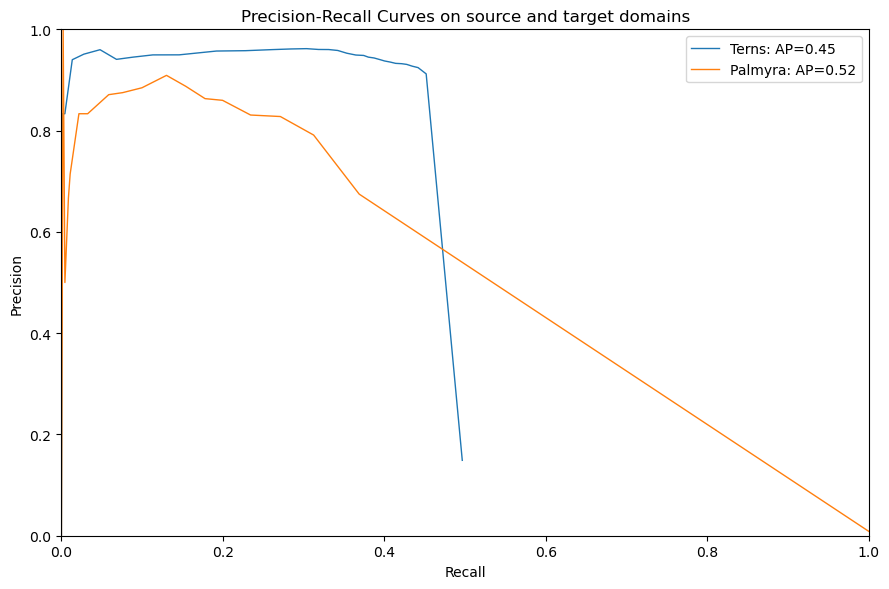

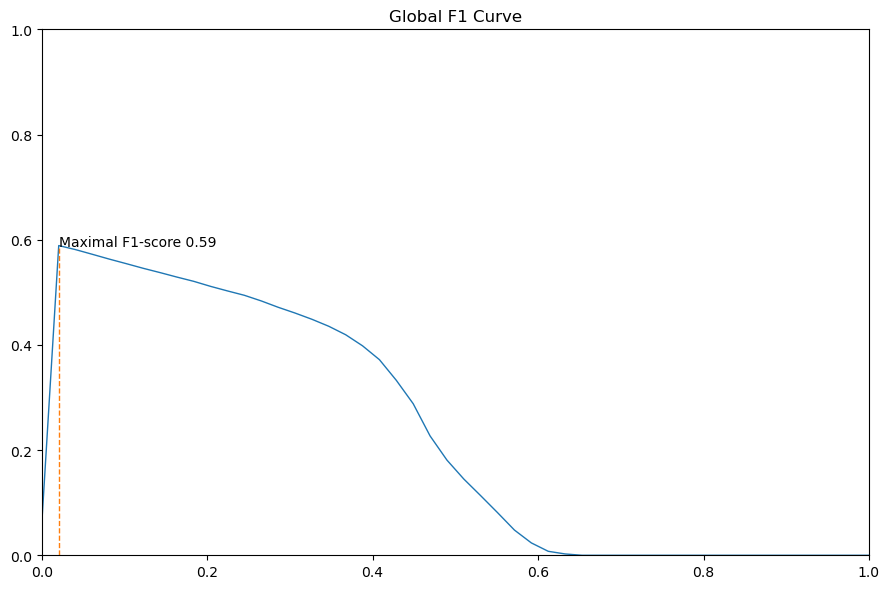

In [28]:
EVAL_FILE = "evaluation_results.json"

# Predictions parameters
eps = 1e-8

models_folder = '/home/eec42/BirdDetector/runs/detect/'
DATASET = 'te_palm_10percent_background'

SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']
MODEL_NAME = 'DAN_' + DATASET
model_dir = os.path.join(models_folder, MODEL_NAME)
results = os.path.join(model_dir, 'eval', EVAL_FILE)
with open(results) as json_data:
    data = json.load(json_data)
    json_data.close()
#data = json.load(results)
conf_thresholds = data['confidence_thresholds']
FN = np.array(data['results_metrics']['FN'])
FP = np.array(data['results_metrics']['FP'])
TN = np.array(data['results_metrics']['TN'])
TP = np.array(data['results_metrics']['TP'])
print(data['datasets'])

source_datasets_indices = [1]
target_datasets_indices = [0]

source_precision = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FP[source_datasets_indices, :], axis=0) + eps)
source_recall = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FN[source_datasets_indices, :], axis=0) + eps)
target_precision = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FP[target_datasets_indices, :], axis=0) + eps)
target_recall = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FN[target_datasets_indices, :], axis=0) + eps)

global_precision = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
global_recall = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
                                     
source_f1 = 2*(source_precision*source_recall)/(source_precision+source_recall+eps)
target_f1 = 2*(target_precision*target_recall)/(target_precision+target_recall+eps)
global_f1 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
best_f1 = np.max(global_f1)
best_f1_conf = conf_thresholds[np.argmax(global_f1)]


# Compute Average Precision & plot PR curves
source_AP = metrics.auc(y=source_precision, x=source_recall)
target_AP = metrics.auc(y=target_precision, x=target_recall)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)
ax.plot(source_recall, source_precision, linewidth=1, label=f'Terns: AP={source_AP:.2f}')  # plot(recall, precision)
ax.plot(target_recall, target_precision, linewidth=1, label=f'Palmyra: AP={target_AP:.2f}')  # plot(recall, precision)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc='upper right')
#ax.text(0.05, 0.95, f'Average Precision = {round(area, 2)}', transform=ax.transAxes, fontsize=14)
ax.set_title(f'Precision-Recall Curves on source and target domains')
fig.savefig(os.path.join(models_folder, MODEL_NAME + 'PRcurve_SourceTarget.jpg'), dpi=250)
plt.show()
plt.close(fig)


# Plot F1 curve with best F1
fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)
ax.plot(conf_thresholds, global_f1, linewidth=1)  # plot(recall, precision)
ax.plot([best_f1_conf,best_f1_conf], [0,best_f1], '--', linewidth=1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.annotate(f'Maximal F1-score {best_f1:.2f}', xy=(best_f1_conf,best_f1))
ax.set_title(f'Global F1 Curve')
fig.savefig(os.path.join(models_folder, MODEL_NAME + 'F1curve_Global.jpg'), dpi=250)
plt.show()
plt.close(fig)


{'source': ['global_birds_palmyra', 'terns_africa']}
{'source': ['global_birds_palmyra', 'terns_africa']}


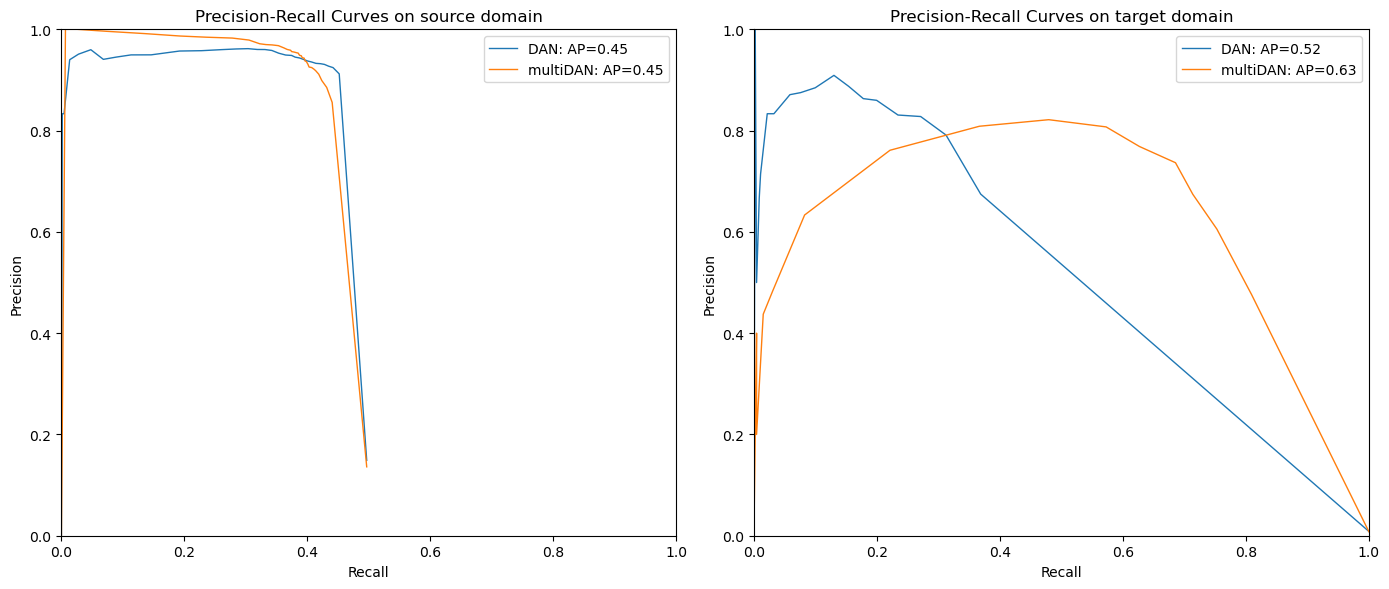

In [12]:
EVAL_FILE = "evaluation_results.json"

# Predictions parameters
eps = 1e-8

models_folder = '/home/eec42/BirdDetector/runs/detect/'
DATASET = 'te_palm_10percent_background'

SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']

tasks = ['DAN', 'multiDAN']

fig, ax = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
for task in tasks:

    MODEL_NAME = task + '_' + DATASET
    model_dir = os.path.join(models_folder, MODEL_NAME)
    results = os.path.join(model_dir, 'eval', EVAL_FILE)
    with open(results) as json_data:
        data = json.load(json_data)
        json_data.close()
    conf_thresholds = data['confidence_thresholds']
    FN = np.array(data['results_metrics']['FN'])
    FP = np.array(data['results_metrics']['FP'])
    TN = np.array(data['results_metrics']['TN'])
    TP = np.array(data['results_metrics']['TP'])
    print(data['datasets'])

    source_datasets_indices = [1]
    target_datasets_indices = [0]

    source_precision = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FP[source_datasets_indices, :], axis=0) + eps)
    source_recall = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FN[source_datasets_indices, :], axis=0) + eps)
    target_precision = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FP[target_datasets_indices, :], axis=0) + eps)
    target_recall = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FN[target_datasets_indices, :], axis=0) + eps)

    global_precision = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
    global_recall = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
                                        
    source_f1 = 2*(source_precision*source_recall)/(source_precision+source_recall+eps)
    target_f1 = 2*(target_precision*target_recall)/(target_precision+target_recall+eps)
    global_f1 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
    best_f1 = np.max(global_f1)
    best_f1_conf = conf_thresholds[np.argmax(global_f1)]

    # Compute Average Precision & plot PR curves
    source_AP = metrics.auc(y=source_precision, x=source_recall)
    target_AP = metrics.auc(y=target_precision, x=target_recall)

    ax[0].plot(source_recall, source_precision, linewidth=1, label=f'{task}: AP={source_AP:.2f}')  # plot(recall, precision)
    ax[1].plot(target_recall, target_precision, linewidth=1, label=f'{task}: AP={target_AP:.2f}')  # plot(recall, precision)


ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[0].legend(loc='upper right')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[1].legend(loc='upper right')
#ax.text(0.05, 0.95, f'Average Precision = {round(area, 2)}', transform=ax.transAxes, fontsize=14)
ax[0].set_title(f'Precision-Recall Curves on source domain')
ax[1].set_title(f'Precision-Recall Curves on target domain')

fig.savefig(os.path.join(models_folder, DATASET + '_PRcurves_multi_architectures.jpg'), dpi=250)
plt.show()
plt.close(fig)


In [13]:
source_precision

array([    0.13604,     0.85571,     0.88529,     0.89897,     0.91136,     0.91847,     0.92149,     0.92448,     0.92556,     0.93138,     0.93661,     0.93758,     0.94315,     0.94402,     0.94777,     0.94874,     0.95316,      0.9536,     0.95514,     0.95608,      0.9587,     0.96027,     0.96336,     0.96777,
           0.96921,      0.9699,      0.9715,     0.97884,     0.98276,     0.98445,      0.9868,      0.9916,     0.99611,           1,           1,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                 0,           0])

In [15]:
source_recall

array([    0.49642,     0.44024,     0.43136,     0.42333,     0.41846,      0.4133,     0.41043,     0.40699,     0.40269,     0.40069,     0.39811,      0.3961,     0.39467,     0.39152,     0.39008,     0.38722,     0.38492,     0.38292,     0.37833,     0.37432,      0.3726,     0.36715,     0.36171,     0.35282,
           0.34279,     0.33247,     0.32244,     0.30496,     0.27773,     0.23588,     0.19289,     0.13528,    0.073373,    0.025795,   0.0065921,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                 0,           0])

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)
for task in tasks:

    MODEL_NAME = task + DATASET
    model_dir = os.path.join(models_folder, MODEL_NAME)
    results = os.path.join(model_dir, 'eval', EVAL_FILE)
    with open(results) as json_data:
        data = json.load(json_data)
        json_data.close()
    conf_thresholds = data['confidence_thresholds']
    FN = np.array(data['results_metrics']['FN'])
    FP = np.array(data['results_metrics']['FP'])
    TN = np.array(data['results_metrics']['TN'])
    TP = np.array(data['results_metrics']['TP'])
    print(data['datasets'])

    source_datasets_indices = [1]
    target_datasets_indices = [0]

    source_precision = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FP[source_datasets_indices, :], axis=0) + eps)
    source_recall = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FN[source_datasets_indices, :], axis=0) + eps)
    target_precision = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FP[target_datasets_indices, :], axis=0) + eps)
    target_recall = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FN[target_datasets_indices, :], axis=0) + eps)

    global_precision = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
    global_recall = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
                                        
    source_f1 = 2*(source_precision*source_recall)/(source_precision+source_recall+eps)
    target_f1 = 2*(target_precision*target_recall)/(target_precision+target_recall+eps)
    global_f1 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
    best_f1 = np.max(global_f1)
    best_f1_conf = conf_thresholds[np.argmax(global_f1)]

    # Compute Average Precision & plot PR curves
    source_AP = metrics.auc(y=source_precision, x=source_recall)
    target_AP = metrics.auc(y=target_precision, x=target_recall)

    ax.plot(conf_thresholds, global_f1, linewidth=1, label=f'{task}: F1-score={source_AP:.2f}')  # plot(recall, precision)
    ax.plot([best_f1_conf,best_f1_conf], [0,best_f1], '+', linewidth=1)
    ax.annotate(f'Maximal F1-score {best_f1:.2f}', xy=(best_f1_conf,best_f1))

    
ax.set_title(f'Global F1 Curve')
fig.savefig(os.path.join(models_folder, DATASET + '_F1curve_multi_architectures.jpg'), dpi=250)
plt.show()
plt.close(fig)



array([[          0,         291,         317,         336,         353,         369,         379,         390,         401,         415,         426,         434,         446,         451,         456,         457,         459,         460,         461,         461,         461,         461,         461,
                461,         461,         461,         461,         461,         461,         461,         461,         461,         461,         461,         461,         461,         461,         461,         461,         461,         461,         461,         461,         461,         461,         461,
                461,         461,         461,         461],
       [       1757,        1913,        1948,        1973,        1997,        2019,        2045,        2069,        2093,        2111,        2138,        2163,        2183,        2217,        2256,        2295,        2334,        2378,        2430,        2497,        2578,        2694,        2819,
               298